In [2]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


sparse_dir = os.path.join(project_dir, 'modules/Sparse')
if sparse_dir not in sys.path:
    sys.path.append(sparse_dir)

from matplotlib import pyplot as plt

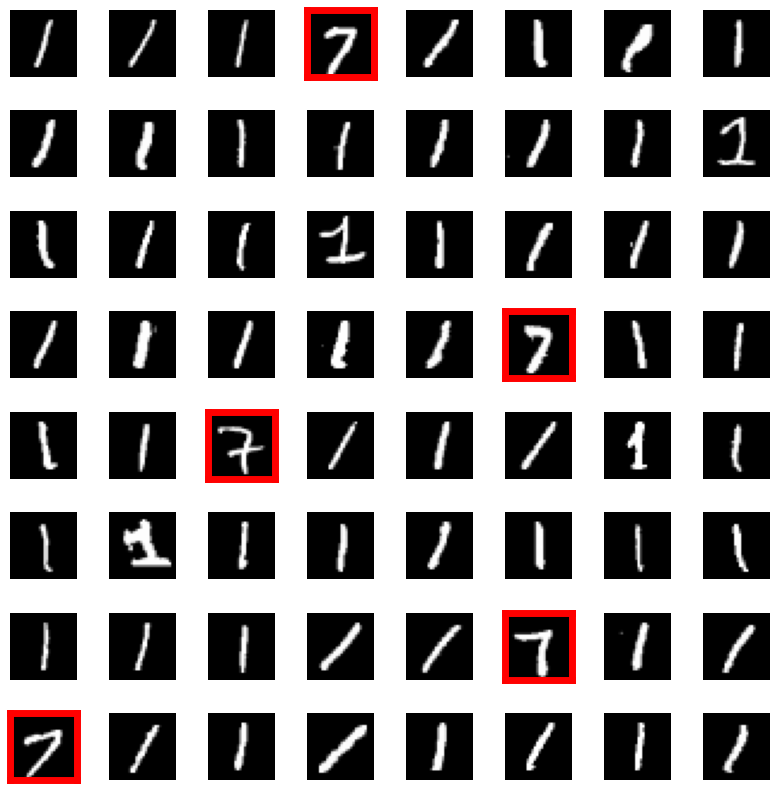

In [7]:
from dataset import AnomalyMNIST
seed = 64
dataset = AnomalyMNIST('data/', n_known_anomalies=512, seed=seed)
dataset.montage(8, 8, seed)
plt.show()

# Dataset

In [95]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomRotation(10),
    # transforms.Normalize((0.5,), (0.5,))
])

dataset_full = MNIST('data/', train = True, download = True, transform = data_transform)
# idx = torch.where((dataset_full.targets == 0) | (dataset_full.targets == 2))[0]
normal_idx = torch.where((dataset_full.targets == 1))[0]
anomaly_idx = torch.where((dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx, anomaly_idx[:512]])

# change labels to 0 and 1, the rest to -1
dataset_full.targets = torch.ones_like(dataset_full.targets) * -1
dataset_full.targets[normal_idx] = 0
dataset_full.targets[anomaly_idx] = 1

# fake_normal = anomaly_idx[-256:]
# dataset_full.targets[fake_normal] = 0


x_train_set = Subset(dataset_full, idx)
train_loader =  DataLoader(x_train_set, 512, shuffle=True)

# Test set
test_dataset_full = MNIST('data/', train = False, download = True, transform = data_transform)
normal_idx = torch.where((test_dataset_full.targets == 1))[0]
anomaly_idx = torch.where((test_dataset_full.targets == 7))[0]
idx = torch.cat([normal_idx[:256], anomaly_idx[:256]])

test_dataset_full.targets = torch.ones_like(test_dataset_full.targets) * -1
test_dataset_full.targets[normal_idx] = 0
test_dataset_full.targets[anomaly_idx] = 1

x_test_set = Subset(test_dataset_full, idx)
test_loader =  DataLoader(x_test_set, 512, shuffle=False)

In [110]:
len(x_train_set) 

7254

In [96]:
test_dataset_full.targets

tensor([ 1, -1,  0,  ..., -1, -1, -1])

tensor(1)


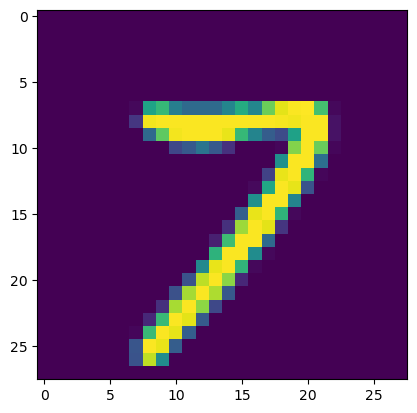

In [97]:
# TO REMOVE! Just testing!
x, y = next(iter(train_loader))
plt.imshow(x[0,0])
print(y[0])

In [98]:
x.max()

tensor(1.)

In [99]:
from Sparse.modules.variational import VariationalLayer
from Sparse.modules.variational.utils import SGVBL
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from torch import nn

# class VariationalEncoder(nn.Linear, nn.Module, VariationalLayer):
#     def __init__(self, in_features, out_features, bias=True) -> None:
#         super(VariationalEncoder, self).__init__(in_features, out_features, bias)
#         self.log_sigma_weight = Parameter(torch.Tensor(out_features, in_features))
#         self.log_sigma_bias = Parameter(torch.Tensor(out_features))
#         torch.nn.init.xavier_uniform_(self.log_sigma_weight)
#         self.log_sigma_bias.data.fill_(-5)
#         self.mu, self.sigma = None, None

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         mu = F.linear(x, self.weight, self.bias) 
#         # sigma = torch.exp(F.linear(x, self.log_sigma_weight))
#         # sigma = torch.exp(F.linear(x, self.log_sigma_weight, self.log_sigma_bias))
#         # sigma = torch.exp(0.5 * F.linear(x*x, self.log_sigma_weight, self.log_sigma_bias))
#         sigma = torch.exp(0.5 * F.linear(x, self.log_sigma_weight, self.log_sigma_bias))

#         if self.training:
#             self.mu, self.sigma = mu, sigma

#         # Reparameterization trick
#         eps = torch.normal(0, torch.ones_like(sigma))
#         return mu + sigma * eps

#     def kl_reg(self):
#         # KL-Divergence regularization $D_{KL}(\mathcal{N}(;\mu_\theta, \sigma_\theta) | \mathcal{N}(;\0, I))$
#         # More details in https://arxiv.org/abs/1312.6114.
#         return .5 * (self.mu**2 + self.sigma**2 - torch.log(self.sigma**2) - 1).sum()

class VariationalEncoder(nn.Linear, VariationalLayer):
    '''
        This implementation is for anomaly detection.
    '''
    def __init__(self, in_features, out_features, bias=True, sigma_anomaly=3) -> None:
        super(VariationalEncoder, self).__init__(in_features, out_features, bias)
        self.log_sigma_weight = Parameter(torch.Tensor(out_features, in_features))
        self.log_sigma_bias = Parameter(torch.Tensor(out_features))
        torch.nn.init.xavier_uniform_(self.log_sigma_weight)
        self.log_sigma_bias.data.fill_(-5)
        self.mu, self.sigma = None, None

        self.sigma_anomaly = sigma_anomaly

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu = F.linear(x, self.weight, self.bias) 
        # sigma = torch.exp(F.linear(x, self.log_sigma_weight))
        # sigma = torch.exp(F.linear(x, self.log_sigma_weight, self.log_sigma_bias))
        # sigma = torch.exp(0.5 * F.linear(x*x, self.log_sigma_weight, self.log_sigma_bias))
        sigma = torch.exp(0.5 * F.linear(x, self.log_sigma_weight, self.log_sigma_bias))

        # if self.training:
        self.mu, self.sigma = mu, sigma

        # Reparameterization trick
        eps = torch.normal(0, torch.ones_like(sigma))
        return mu + sigma * eps

    def kl_reg(self, targets: torch.Tensor) -> torch.Tensor:
        # KL-Divergence regularization
        assert torch.all((targets == 0) | (targets == 1))
        sigma_2 = (torch.ones_like(targets) + ((self.sigma_anomaly-1) * targets)).unsqueeze(1).cuda()
        # print(sigma_2.shape)
        # print(self.sigma.shape)
        # print(self.mu.shape)
        result = (torch.log(sigma_2) - torch.log(self.sigma) + (self.sigma**2 + self.mu**2)/(2*sigma_2**2) - 0.5)
        # print(result.shape)
        return result.sum()

In [100]:
from torch import nn
from torch.nn.functional import cross_entropy
from Sparse.modules.variational import VariationalLayer

class SGVBL(nn.Module):
    ''' 
        Stocastich Gradient Variational Bayes (SGVB) Loss function.
        More details in https://arxiv.org/pdf/1506.02557.pdf and https://arxiv.org/pdf/1312.6114.pdf
    '''

    def __init__(self, model, train_size, loss=cross_entropy):
        super(SGVBL, self).__init__()
        self.train_size = train_size
        self.net = model
        self.loss = loss

        self.variational_layers = []
        for module in model.modules():
            if isinstance(module, (VariationalLayer)):
                self.variational_layers.append(module)

    def forward(self, input, output, target, kl_weight=1.0):
        assert output.requires_grad
        kl = 0.0
        for layer in self.variational_layers:
            kl += layer.kl_reg(target)
            
        return self.loss(input, output) * self.train_size + kl_weight * kl

In [101]:
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_size, latent_space):
        super(VAE, self).__init__()
        conv_out_size = input_size // (2*2)
        self.encoder = nn.Sequential(
            nn.Conv2d(1,8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(8, 12, 3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.Dropout2d(0.2),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(12*(conv_out_size**2), 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.ReLU(),
        )

        self.botleneck = VariationalEncoder(128, latent_space)

        self.decoder = nn.Sequential(
            nn.Linear(latent_space, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(128, 12*(conv_out_size**2)),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Unflatten(1, (12, conv_out_size, conv_out_size)),
            nn.BatchNorm2d(12),
            nn.Conv2d(12, 8, 3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 1, 3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            # nn.Sigmoid()
        )


    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.botleneck(x)
        x = self.decoder(x)
        return x

model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), loss=mse_loss)

In [102]:
x, _ = next(iter(train_loader))
x.shape

torch.Size([512, 1, 28, 28])

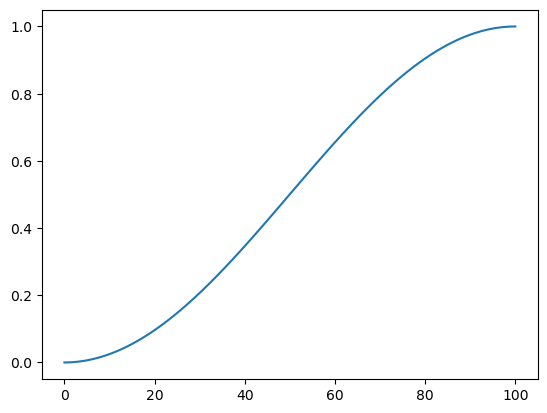

In [103]:
import math 
def cosine_scheduler(timesteps, s=8e-3):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x/timesteps)+s) / (1+s) * math.pi * .5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    return 1 - alphas_cumprod

from matplotlib import pyplot as plt
plt.plot(cosine_scheduler(100, 1e-3))
plt.show()

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 50
from tqdm import tqdm
# kl_weight = 0.02

epoch_iterator = tqdm(
        range(n_epochs),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % -1},
    )

kl_weight = torch.clip(cosine_scheduler(n_epochs), 0, .99)

opt = torch.optim.Adam(model.parameters())
for epoch in epoch_iterator:
    epoch_loss = 0.
    # kl_weight = min(kl_weight+0.012, .9)
    for x, y in train_loader:
        # check if there are a target with 1
        # if torch.any(y == 1):
            # print("Anomaly detected")
            # break
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = torch.sigmoid(model(x))
        # x_hat = torch.tanh(model(x))
        loss = sgvbl(x, x_hat, y, kl_weight[epoch])
        # loss = sgvbl(x, x_hat, y, kl_weight)
        epoch_loss += loss.detach().item()

        loss.backward()
        opt.step()
    
    epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

  0%|          | 0/50 [00:00<?, ?epoch/s, tls=-1.0000]

100%|██████████| 50/50 [00:45<00:00,  1.10epoch/s, tls=283.312]


In [105]:
# def plot_latent(autoencoder, data, num_batches=100):
#     for i, (x, y) in enumerate(data):
#         z = autoencoder.botleneck(autoencoder.encoder(x.to(device)))
#         z = z.to('cpu').detach().numpy()
#         plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#         if i > num_batches:
#             plt.colorbar()
#             return
        
#     plt.colorbar()

import numpy as np

# plot latent space where green is for normal samples and blue for anomalies
def plot_latent(model, data, num_batches=100):
    model.eval()
    fig = plt.figure(figsize=(5,5))
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            z = model.botleneck(model.encoder(x))
            z = z.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            anomalies = np.where(y == 1)
            normal = np.where(y == 0)
            if i == 0:
                plt.scatter(z[normal, 0], z[normal, 1], c='r', alpha=.7, label='normal')
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b', alpha=.7, label='anomalies')
            else:
                plt.scatter(z[normal, 0], z[normal, 1], c='r',alpha=.7)
                plt.scatter(z[anomalies, 0], z[anomalies, 1], c='b',alpha=.7)
           
            if i > num_batches:
                plt.legend()
                return
    plt.legend()
    return fig



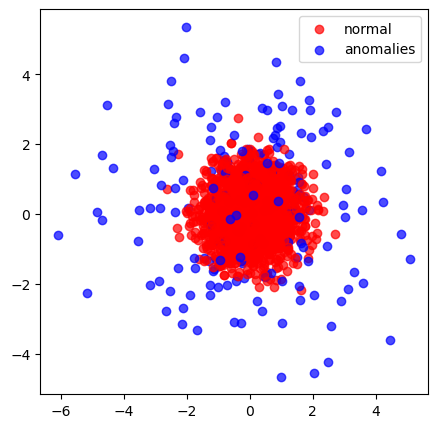

In [106]:
dataset_full.targets[fake_normal] = 25
model.eval()
# model.train()
fig = plot_latent(model, train_loader, num_batches=3)
plt.savefig('latent_space.png')
plt.show()

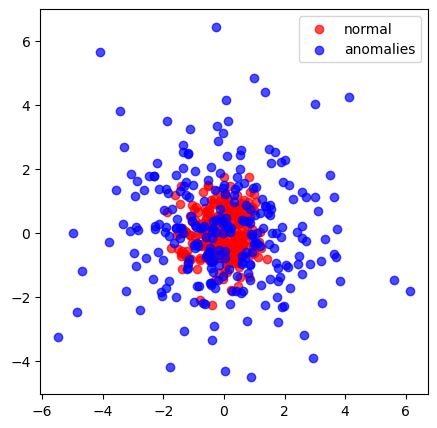

In [107]:
model.eval()
# model.train()
fig = plot_latent(model, test_loader, num_batches=25)
plt.savefig('latent_space_test.png', dpi=300, bbox_inches='tight')

torch.Size([1, 1, 28, 28])


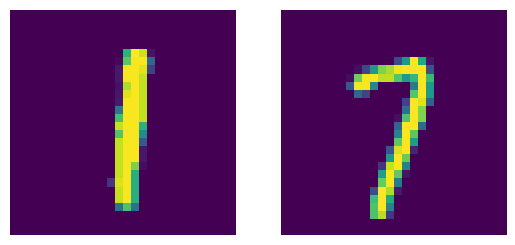

In [89]:
x, y = next(iter(test_loader))
x_0 = x[torch.argwhere(y==0).squeeze()[150]].unsqueeze(0)
x_1 = x[torch.argwhere(y==1).squeeze()[152]].unsqueeze(0)

print(x_0.shape)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(x_1[0,0])
plt.axis('off')
plt.savefig('anomalies.png', bbox_inches='tight')
# model.train()
model.eval()
z_0, z_1 = [], []
for i in range(100):
    z_0.append(model.botleneck(model.encoder(x_0.to(device))).detach().cpu())
    z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

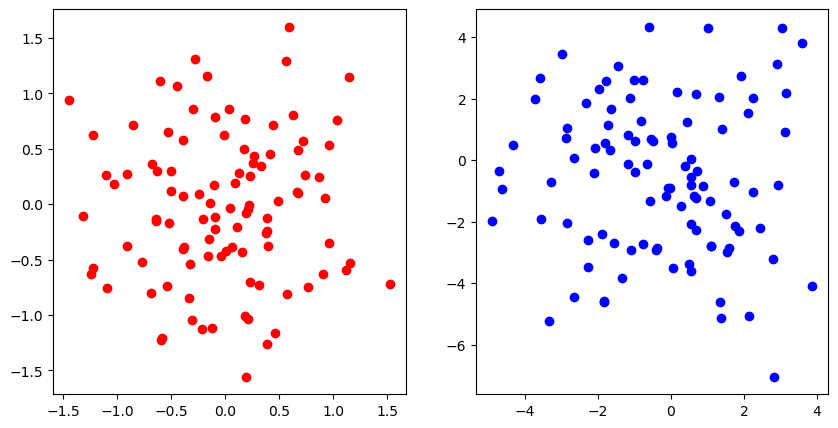

In [109]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')
plt.savefig('anomalies_latent_sample.png', bbox_inches='tight')

In [83]:
x = torch.cat([x_0, x_1]).to(device)
print(x.shape)
# model.train()
model.eval()
with torch.no_grad():
    x_hat = model(x)

model.botleneck.sigma.detach(), model.botleneck.mu.detach()

torch.Size([2, 1, 28, 28])


(tensor([[0.7191, 0.7161],
         [2.1498, 2.1900]], device='cuda:0'),
 tensor([[-0.0002, -0.0011],
         [-0.0151,  0.0021]], device='cuda:0'))

In [123]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    fig = plt.figure(figsize=(5, 5))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = torch.sigmoid(autoencoder.decoder(z))
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel('$\mathcal{N}(x;0,\sigma_1)$')
    plt.ylabel('$\mathcal{N}(x;0,\sigma_2)$')
    # plt.axis('off')
    return fig

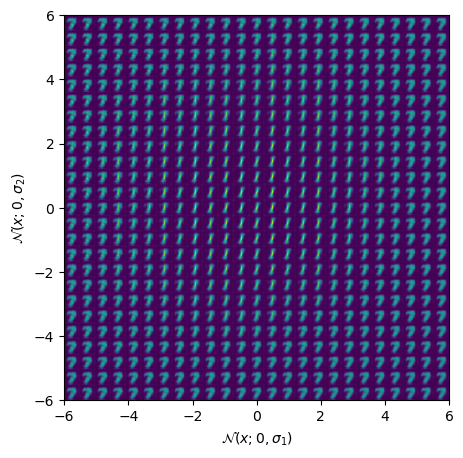

In [124]:
model.eval()
fig = plot_reconstructed(model.to(device), r0=(-6, 6), r1=(-6, 6), n=25)
plt.savefig('reconstructed.png', dpi=300, bbox_inches='tight')
plt.show(fig)

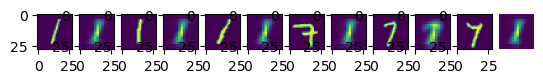

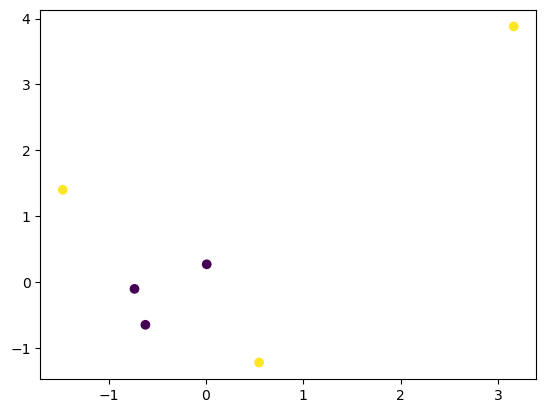

In [74]:
test_idx = torch.linspace(0, 511, 6, dtype=int)
x, y = next(iter(test_loader))
x_hat = torch.sigmoid(model(x.cuda()).detach().cpu())
z = model.botleneck(model.encoder(x.cuda())).detach().cpu()

for i, idx in enumerate(test_idx):
    plt.subplot(1, 2*len(test_idx), 2*(i+1)-1)
    plt.imshow(x[idx, 0])

    plt.subplot(1, 2*len(test_idx), 2*(i+1))
    plt.imshow(x_hat[idx,0])

plt.axis('off')
plt.show()
# plt.subplot(1,2,1)
# plt.imshow(x[260,0])

# x_hat = torch.sigmoid(model(x.cuda()).detach().cpu())

# plt.subplot(1,2,2)
# plt.imshow(x_hat[0,0])

# mse_loss(x, x_hat)

plt.scatter(z[test_idx, 0], z[test_idx, 1], c=y[test_idx] )
plt.show()

In [78]:
test_idx[-2]

tensor(408)

In [46]:
x.shape

torch.Size([512, 1, 28, 28])

## MedMNIST

In [159]:
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data


print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


In [160]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [62]:

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 4170669/4170669 [00:05<00:00, 804315.24it/s] 


Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/abian/.medmnist/pneumoniamnist.npz


In [698]:
type(test_dataset.labels)

numpy.ndarray

In [643]:
next(iter(test_loader))[0].shape

torch.Size([256, 1, 28, 28])

/home/abian/Workspace/Anaconda/envs/DeepLearning/lib/python3.10/site-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


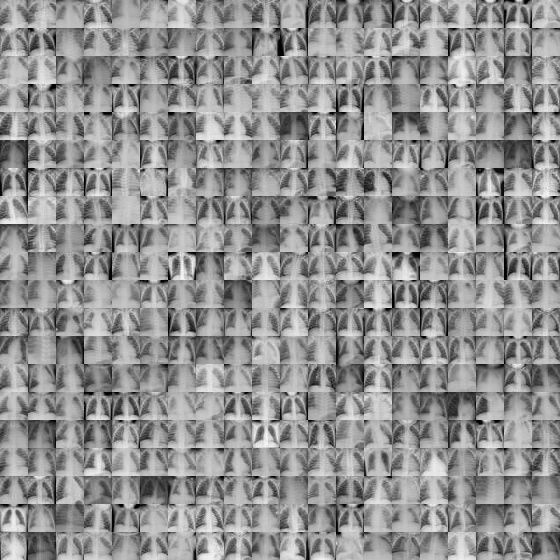

In [676]:
train_dataset.montage(length=20)

In [721]:
train_dataset.labels
normal_idx = torch.tensor(np.where((train_dataset.labels == 1))[0])
anomaly_idx = torch.tensor(np.where((train_dataset.labels == 0))[0])

idx = torch.cat([normal_idx, anomaly_idx[:512]])

# change labels to 0 and 1, the rest to -1
train_dataset.labels = np.ones_like(dataset_full.targets) * -1
train_dataset.labels[normal_idx] = 0
train_dataset.labels[anomaly_idx] = 1

x_train_set = Subset(train_dataset, idx)
train_loader =  DataLoader(x_train_set, 128, shuffle=True)
# normal_idx = torch.where((dataset_full.targets == 7))[0]
# anomaly_idx = torch.where((dataset_full.targets == 1))[0]

In [722]:
normal_idx.shape, anomaly_idx.shape

(torch.Size([3494]), torch.Size([1214]))

In [723]:
model = VAE(28, 2)
from torch.nn.functional import mse_loss
sgvbl = SGVBL(model, len(x_train_set), loss=mse_loss)

In [724]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()
n_epochs = 100
from tqdm import tqdm
# kl_weight = 0.02

epoch_iterator = tqdm(
        range(n_epochs),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % -1},
    )

kl_weight = torch.clip(cosine_scheduler(n_epochs), 0, 0.99)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in epoch_iterator:
    epoch_loss = 0.
    # kl_weight = min(kl_weight+0.012, .9)
    for x, y in train_loader:
        # check if there are a target with 1
        # if torch.any(y == 1):
            # print("Anomaly detected")
            # break
        x = x.to(device) # GPU
        opt.zero_grad()
        x_hat = torch.tanh(model(x))
        loss = sgvbl(x, x_hat, y, kl_weight[epoch])
        # loss = sgvbl(x, x_hat, y, 1e-2)
        # loss = sgvbl(x, x_hat, y, kl_weight)
        epoch_loss += loss.detach().item()

        loss.backward()
        opt.step()
    
    epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

100%|██████████| 100/100 [01:14<00:00,  1.35epoch/s, tls=281.525]


In [703]:
# # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model.to(device)
# # model.train()
# # n_epochs = 200
# # from tqdm import tqdm
# # kl_weight = 0.02

# # opt = torch.optim.Adam(model.parameters())
# # for epoch in tqdm(range(n_epochs)):
# #     kl_weight = min(kl_weight+0.006, 1)
# #     for x, y in train_loader:
# #         x = x.to(device) # GPU
# #         opt.zero_grad()
# #         x_hat = model(x)
# #         loss = sgvbl(x, x_hat, kl_weight)
# #         loss.backward()
# #         opt.step()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# model.train()
# n_epochs = 100
# from tqdm import tqdm
# kl_weight = 0.02

# epoch_iterator = tqdm(
#         range(n_epochs),
#         leave=True,
#         unit="epoch",
#         postfix={"tls": "%.4f" % -1},
#     )

# opt = torch.optim.Adam(model.parameters())
# for epoch in epoch_iterator:
#     epoch_loss = 0.
#     kl_weight = min(kl_weight+0.001, 1)
#     for x, y in train_loader:
#         # check if there are a target with 1
#         # if torch.any(y == 1):
#         #     print("Anomaly detected")
#         x = x.to(device) # GPU
#         opt.zero_grad()
#         x_hat = model(x)
#         loss = sgvbl(x, x_hat, y, kl_weight)
#         epoch_loss += loss.detach().item()

#         loss.backward()
#         opt.step()

#     epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))


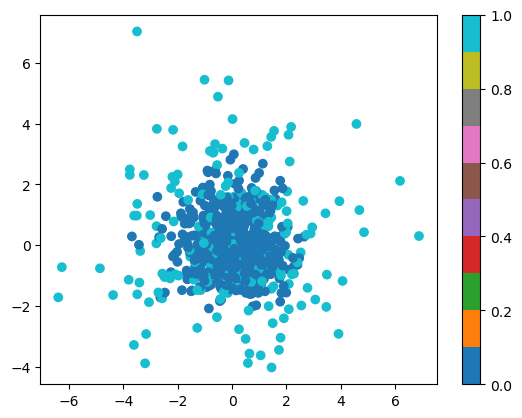

In [732]:
model.eval()
# model.train()
plot_latent(model, train_loader_at_eval, num_batches=1)

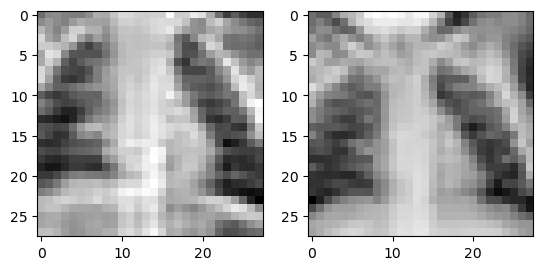

In [726]:
x, y = next(iter(train_loader))
x_0 = x[np.argwhere(y==0)[0].squeeze()[0]].unsqueeze(0)
x_1 = x[np.argwhere(y==1)[0].squeeze()[0]].unsqueeze(0)

plt.subplot(1,2,1)
plt.imshow(x_0[0,0], cmap='gray')
plt.subplot(1,2,2)https://ieeexplore.ieee.org/xpl/RecentIssue.jsp?punumber=5962385
    z_1.append(model.botleneck(model.encoder(x_1.to(device))).detach().cpu())

In [727]:
x = torch.cat([x_0, x_1])
z = model.botleneck(model.encoder(x.to(device))).detach().cpu()
model.botleneck.sigma, model.botleneck.mu

(tensor([[1.0594, 0.8419],
         [1.8045, 1.4648]], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor([[-0.0226,  0.3722],
         [-0.0788,  0.0468]], device='cuda:0', grad_fn=<AddmmBackward0>))

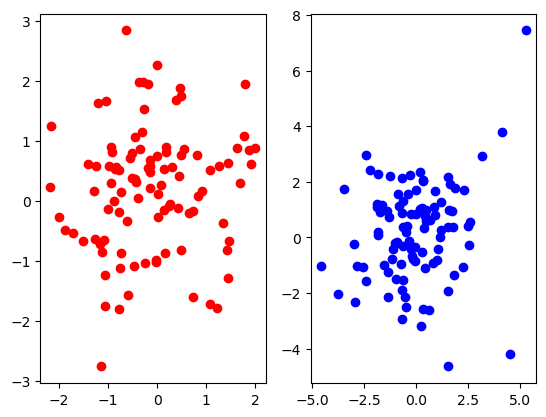

In [728]:
plt.subplot(1,2,1)
plt.scatter(torch.cat(z_0)[:,0], torch.cat(z_0)[:,1], c='r')
plt.subplot(1,2,2)
plt.scatter(torch.cat(z_1)[:,0], torch.cat(z_1)[:,1], c='b')

(tensor(0.0626, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0793, device='cuda:0', grad_fn=<MseLossBackward0>))

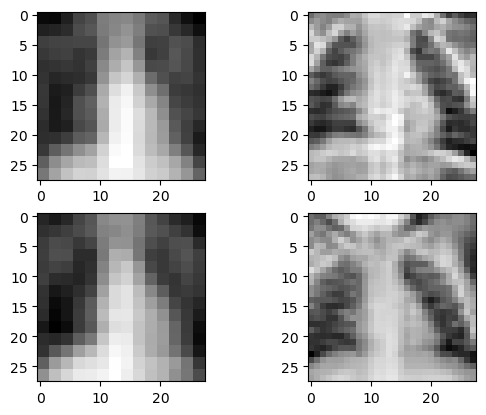

In [729]:
x_hat = model(x_0.to(device))
plt.subplot(2,2,1)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(x_0[0,0], cmap='gray')

x_hat = model(x_1.to(device))
plt.subplot(2,2,3)
plt.imshow(x_hat[0,0].detach().cpu(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(x_1[0,0], cmap='gray')

mse_loss(x_hat, x_0.to(device)), mse_loss(x_hat, x_1.to(device))

In [730]:
import numpy as np
def plot_reconstructed(autoencoder, r0=(-10, 10), r1=(-10, 10), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = torch.tanh(autoencoder.decoder(z))
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

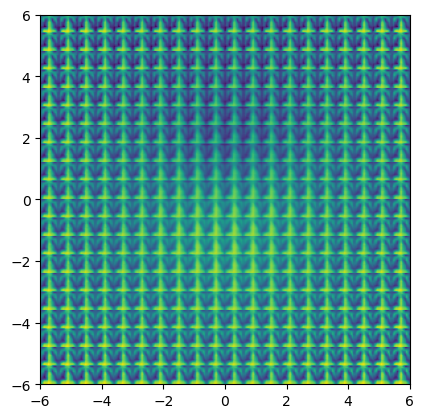

In [731]:
model.eval()
plot_reconstructed(model, r0=(-6, 6), r1=(-6, 6), n=20)